In [2]:
# Import libraries
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from matplotlib import pyplot as plt
import xgboost as xgb
from sklearn.inspection import permutation_importance

from model_functions import select_variables
from model_functions import train_xgb_model
from plotting_functions import plot_gsearch_results
from plotting_functions import plot_prediction_per_fold
from plotting_functions import plot_prediction
from plotting_functions import plot_prediction_subplot

In [3]:
# Specify filepaths and filenames.
loc = 'local'

if loc == 'cryocloud':
    filepath = '/home/jovyan/ML_MB_Norway_data/'
elif loc == 'local':
    filepath = 'Data/'

filename = '2023-08-28_stake_mb_norway_cleaned_ids_latlon_wattributes_climate.csv'

# Load data.
data = pd.read_csv(filepath + filename)

# Add year column
data['year']=pd.to_datetime(data['dt_curr_year_max_date'].astype('string'), format="%d.%m.%Y %H:%M")
data['year'] = data.year.dt.year.astype('Int64')

# Remove cells with nan in balance_netto.
glacier_data_annual = data[data['balance_netto'].notna()]
glacier_data_annual.reset_index(drop=True, inplace=True)

glacier_data_winter = data[data['balance_winter'].notna()]
glacier_data_winter.reset_index(drop=True, inplace=True)

glacier_data_summer = data[data['balance_summer'].notna()]
glacier_data_summer.reset_index(drop=True, inplace=True)


C:\Users\kasj\AppData\Local\Temp\ipykernel_20436\3940554349.py:12: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filepath + filename)


In [58]:
# Manually select 11 test glaciers
test_glaciers = [54, 703, 941, 1135, 1280, 2085, 2320, 2478, 2769, 3127, 3141]
#703
df_test_annual = glacier_data_annual[glacier_data_annual['BREID'].isin(test_glaciers)]
df_test_winter = glacier_data_winter[glacier_data_winter['BREID'].isin(test_glaciers)]
df_test_summer = glacier_data_summer[glacier_data_summer['BREID'].isin(test_glaciers)]
# GlacierID has no_annual/no_winter/no_summer points Location
# 54 has 189/174/172 points Finnmark (Langfjordjøkelen)
# 703 has 30/30/31 points Narvik
#NOT USED# 675 has 178 points Narvik
# 941 has 70/71/70 points Blåmannsisen (Bodø)
# 1135 has 56/29/29 points Svartisen sør
# 1280 has 71/57/72 points Breiaren (nær Svartisen)
# 2320 has 83/83/84 points Jostedalsbreen
# 2085 has 163/157/157 points Ålfotbreen
# 2478 has 89/89/89 points Jostedalsbreen
# 2769 has 121/116/116 points Jotunheimen
# 3127 has 145/144/157 points Folgefonna
# 3141 has 72/70/70 points Folgefonna
# Test dataset has 1089/1020/1047 points in total, approximately 27% of the data
# Train dataset has 2821/2732/2882 points, approximately 73% of the data

df_train_annual = glacier_data_annual[~glacier_data_annual['BREID'].isin(test_glaciers)]
df_train_winter = glacier_data_winter[~glacier_data_winter['BREID'].isin(test_glaciers)]
df_train_summer = glacier_data_summer[~glacier_data_summer['BREID'].isin(test_glaciers)]

print(f'Train/test annual: {len(df_train_annual)}/{len(df_test_annual)}')
print(f'Train/test winter: {len(df_train_winter)}/{len(df_test_winter)}')
print(f'Train/test summer: {len(df_train_summer)}/{len(df_test_summer)}')
print(f'All train/test: {len(df_train_annual)+len(df_train_winter)+len(df_train_summer)} / {len(df_test_annual)+len(df_test_winter)+len(df_test_summer)}')
print(f'Fraction train/test: {(len(df_train_annual)+len(df_train_winter)+len(df_train_summer)) / (len(df_test_annual)+len(df_test_winter)+len(df_test_summer)+len(df_train_annual)+len(df_train_winter)+len(df_train_summer))} / {(len(df_test_annual)+len(df_test_winter)+len(df_test_summer)) /(len(df_test_annual)+len(df_test_winter)+len(df_test_summer) + len(df_train_annual)+len(df_train_winter)+len(df_train_summer))}')
print(f'Total entries: {len(df_test_annual)+len(df_test_winter)+len(df_test_summer) + len(df_train_annual)+len(df_train_winter)+len(df_train_summer)}')


Train/test annual: 2821/1089
Train/test winter: 2732/1020
Train/test summer: 2882/1047
All train/test: 8435 / 3156
Fraction train/test: 0.7277197825899405 / 0.27228021741005953
Total entries: 11591


### Distribution of training and test datasets

Train mass balance: median 0.0, min -13.1, max 5.72.
Test mass balance: median -0.8, min -6.3, max 4.1.
Train altitude: mean 1342.933605104573, min 190.0, max 2212.0.
Test altitude: mean 1247.4214876033059, min 390.0, max 2105.0.
Train mean temp: mean -1.835271894059872, min -7.492487335205055, max 3.914905802408896.
Test mean temp: mean -1.3186330175851708, min -7.176125590006507, max 3.888141886393271.
Train prec sum: mean 0.06691555762633712, min 0.026136178523301197, max 0.132155250757932.
Test prec sum: mean 0.0629639654378405, min 0.026136178523301197, max 0.123711260966956.


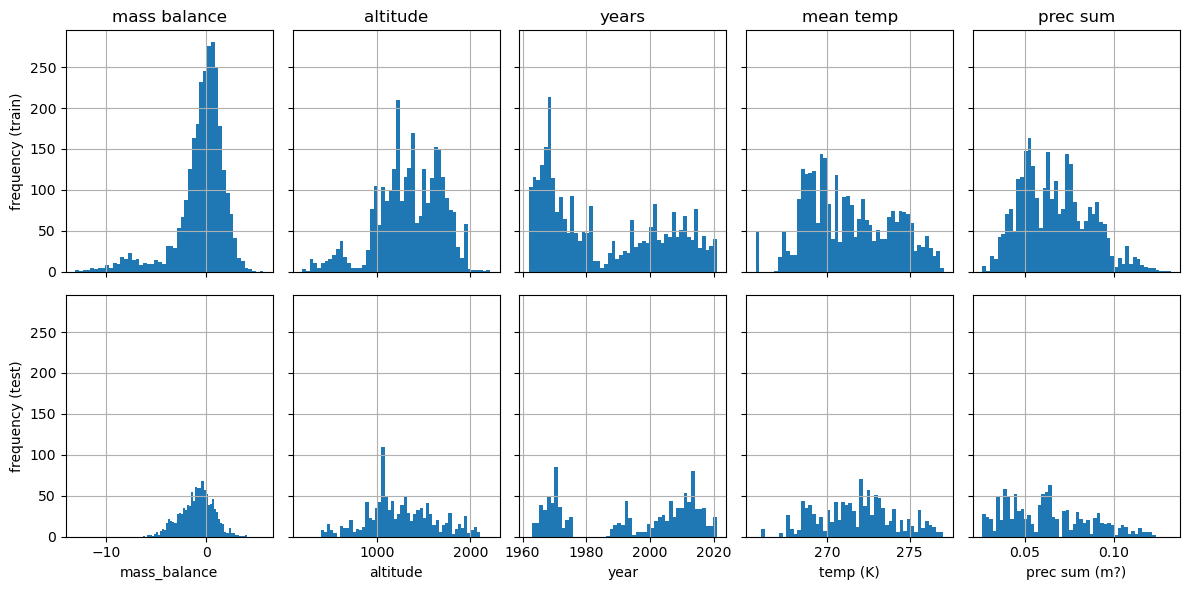

In [59]:
# Number of measurements by topography
temp_cols = ['t2m_oct','t2m_nov','t2m_dec','t2m_jan','t2m_feb','t2m_mar','t2m_apr','t2m_may','t2m_jun','t2m_jul','t2m_aug','t2m_sep']
prec_cols = ['tp_oct','tp_nov','tp_dec','tp_jan','tp_feb','tp_mar','tp_apr','tp_may','tp_jun','tp_jul','tp_aug','tp_sep']

f, ax = plt.subplots(2, 5, figsize=(12,6), sharey=True, sharex='col')
df_train_annual['balance_netto'].plot.hist(bins=50, ax=ax[0,0])
ax[0,0].set_title('mass balance')
ax[0,0].set_ylabel('frequency (train)')
df_train_annual['altitude'].plot.hist(bins=50, ax=ax[0,1])
ax[0,1].set_title('altitude')
df_train_annual['year'].plot.hist(bins=50, ax=ax[0,2])
ax[0,2].set_title('years')
df_train_annual[temp_cols].mean(axis=1).plot.hist(bins=50, ax=ax[0,3])
ax[0,3].set_title('mean temp')
df_train_annual[prec_cols].sum(axis=1).plot.hist(bins=50, ax=ax[0,4])
ax[0,4].set_title('prec sum')

df_test_annual['balance_netto'].plot.hist(bins=50, ax=ax[1,0])
ax[1,0].set_ylabel('frequency (test)')
ax[1,0].set_xlabel('mass_balance')
df_test_annual['altitude'].plot.hist(bins=50, ax=ax[1,1])
ax[1,1].set_xlabel('altitude')
df_test_annual['year'].plot.hist(bins=50, ax=ax[1,2])
ax[1,2].set_xlabel('year')
df_test_annual[temp_cols].mean(axis=1).plot.hist(bins=50, ax=ax[1,3])
ax[1,3].set_xlabel('temp (K)')
df_test_annual[prec_cols].sum(axis=1).plot.hist(bins=50, ax=ax[1,4])
ax[1,4].set_xlabel('prec sum (m?)')

for row in ax:
    for a in row:
        a.grid()

plt.tight_layout()

T_0 = 273.15
print(f"Train mass balance: median {df_train_annual['balance_netto'].median()}, min {df_train_annual['balance_netto'].min()}, max {df_train_annual['balance_netto'].max()}.")
print(f"Test mass balance: median {df_test_annual['balance_netto'].median()}, min {df_test_annual['balance_netto'].min()}, max {df_test_annual['balance_netto'].max()}.")
print(f"Train altitude: mean {df_train_annual['altitude'].mean()}, min {df_train_annual['altitude'].min()}, max {df_train_annual['altitude'].max()}.")
print(f"Test altitude: mean {df_test_annual['altitude'].mean()}, min {df_test_annual['altitude'].min()}, max {df_test_annual['altitude'].max()}.")
print(f"Train mean temp: mean {df_train_annual[temp_cols].mean().mean()-T_0}, min {df_train_annual[temp_cols].mean(axis=1).min()-T_0}, max {df_train_annual[temp_cols].mean(axis=1).max()-T_0}.")
print(f"Test mean temp: mean {df_test_annual[temp_cols].mean().mean()-T_0}, min {df_test_annual[temp_cols].mean(axis=1).min()-T_0}, max {df_test_annual[temp_cols].mean(axis=1).max()-T_0}.")
print(f"Train prec sum: mean {df_train_annual[prec_cols].sum(axis=1).mean()}, min {df_train_annual[prec_cols].sum(axis=1).min()}, max {df_train_annual[prec_cols].sum(axis=1).max()}.")
print(f"Test prec sum: mean {df_test_annual[prec_cols].sum(axis=1).mean()}, min {df_test_annual[prec_cols].sum(axis=1).min()}, max {df_test_annual[prec_cols].sum(axis=1).max()}.")

In [60]:
# Add number of months to each dataframe
df_train_annual['n_months']=12
df_train_winter['n_months']=8
df_train_summer['n_months']=6

C:\Users\kasj\AppData\Local\Temp\ipykernel_20436\1628288660.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_annual['n_months']=12
C:\Users\kasj\AppData\Local\Temp\ipykernel_20436\1628288660.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_winter['n_months']=8
C:\Users\kasj\AppData\Local\Temp\ipykernel_20436\1628288660.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [61]:
# Select columns to drop
cols = ['RGIID','GLIMSID','utm_zone','utm_east_approx','utm_north_approx','altitude_approx',
        'location_description','location_id','stake_no','utm_east','utm_north','dt_prev_year_min_date','dt_curr_year_max_date',
        'dt_curr_year_min_date','stake_remark','flag_correction','approx_loc','approx_altitude',
        'diff_north','diff_east','diff_altitude','diff_netto','lat_approx','lon_approx',
        'topo','dis_from_border','year', 'lat','lon']

snow_depth_m = ['sde_oct','sde_nov','sde_dec','sde_jan','sde_feb','sde_mar','sde_apr','sde_may','sde_jun','sde_jul','sde_aug','sde_sep']
snow_density = ['rsn_oct','rsn_nov','rsn_dec','rsn_jan','rsn_feb','rsn_mar','rsn_apr','rsn_may','rsn_jun','rsn_jul','rsn_aug','rsn_sep']
evaporation = ['es_oct','es_nov','es_dec','es_jan','es_feb','es_mar','es_apr','es_may','es_jun','es_jul','es_aug','es_sep']
snow_cover = ['snowc_oct','snowc_nov','snowc_dec','snowc_jan','snowc_feb','snowc_mar','snowc_apr','snowc_may','snowc_jun','snowc_jul','snowc_aug','snowc_sep']
snow_depth_we = ['sd_oct','sd_nov','sd_dec','sd_jan','sd_feb','sd_mar','sd_apr','sd_may','sd_jun','sd_jul','sd_aug','sd_sep']
snow_temp = ['tsn_oct','tsn_nov','tsn_dec','tsn_jan','tsn_feb','tsn_mar','tsn_apr','tsn_may','tsn_jun','tsn_jul','tsn_aug','tsn_sep']
snow_melt = ['smlt_oct','smlt_nov','smlt_dec','smlt_jan','smlt_feb','smlt_mar','smlt_apr','smlt_may','smlt_jun','smlt_jul','smlt_aug','smlt_sep']
snowfall = ['sf_oct','sf_nov','sf_dec','sf_jan','sf_feb','sf_mar','sf_apr','sf_may','sf_jun','sf_jul','sf_aug','sf_sep']
snow_albedo = ['asn_oct','asn_nov','asn_dec','asn_jan','asn_feb','asn_mar','asn_apr','asn_may','asn_jun','asn_jul','asn_aug','asn_sep']
dewpt_temp = ['d2m_oct','d2m_nov','d2m_dec','d2m_jan','d2m_feb','d2m_mar','d2m_apr','d2m_may','d2m_jun','d2m_jul','d2m_aug','d2m_sep']
surface_pressure = ['sp_oct','sp_nov','sp_dec','sp_jan','sp_feb','sp_mar','sp_apr','sp_may','sp_jun','sp_jul','sp_aug','sp_sep']
sol_rad_net = ['ssr_oct','ssr_nov','ssr_dec','ssr_jan','ssr_feb','ssr_mar','ssr_apr','ssr_may','ssr_jun','ssr_jul','ssr_aug','ssr_sep']
sol_therm_down = ['strd_oct','strd_nov','strd_dec','strd_jan','strd_feb','strd_mar','strd_apr','strd_may','strd_jun','strd_jul','strd_aug','strd_sep']

drop_cols = [y for x in [cols, snow_depth_m, snow_density, evaporation, snow_cover, snow_depth_we, snow_temp, snow_melt, snowfall, snow_albedo, dewpt_temp, surface_pressure, sol_rad_net, sol_therm_down] for y in x]

# Select features for training
df_train_annual_clean = df_train_annual.drop(drop_cols, axis=1)
df_train_winter_clean = df_train_winter.drop(drop_cols, axis=1)
df_train_summer_clean = df_train_summer.drop(drop_cols, axis=1)
df_train_annual_clean = df_train_annual_clean.drop(['balance_winter','balance_summer'], axis=1)
df_train_winter_clean = df_train_winter_clean.drop(['balance_netto', 'balance_summer'], axis=1)
df_train_summer_clean = df_train_summer_clean.drop(['balance_netto', 'balance_winter'], axis=1)

# Rename target columns to same name
df_train_annual_clean.rename(columns={'balance_netto' : 'balance'}, inplace=True)
df_train_winter_clean.rename(columns={'balance_winter' : 'balance'}, inplace=True)
df_train_summer_clean.rename(columns={'balance_summer' : 'balance'}, inplace=True)

# df_train_X_... now contains columns of all chosen features and column with annual, winter or summer balance

In [62]:
# For summer balance, replace column values in accumulation months with NaN (oct, nov, dec, jan, feb, mar, apr, may)
# For winter balance, replace column values in ablation months with NaN (may, jun, jul, aug, sep, oct)

var = ['u10', 'v10', 't2m', 'fal', 'sshf', 'slhf', 'ssr', 'str', 'tp']
mon_summer = ['may', 'jun', 'jul', 'aug', 'sep', 'oct']
mon_winter = ['oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr', 'may']

for name in var:
    for mon in mon_summer:
        df_train_winter_clean[name+'_'+mon]= np.nan
for name in var:   
    for mon in mon_winter:
        df_train_summer_clean[name+'_'+mon]= np.nan

In [63]:
# Combine the three dataframes
df_train_all = pd.concat([df_train_annual_clean, df_train_summer_clean, df_train_winter_clean])


In [64]:
# Shuffle df_train, get X and y values
df_train_s = df_train_all.sample(frac=1, random_state=5)
df_train_s.reset_index(drop=True, inplace=True)

In [65]:
# Select features for training
df_train_X_s = df_train_s.drop(['balance','BREID'], axis=1)

# Select labels for training
df_train_y_s = df_train_s[['balance']]

# Get values
X_train_s, y_train_s = df_train_X_s.values, df_train_y_s.values

# Get glacier IDs from training dataset (in the order of which they appear in training dataset).
# gp_s is an array with shape equal to the shape of X_train_s and y_train_s.
gp_s = np.array(df_train_s['BREID'].values)

# Use five folds
group_kf = GroupKFold(n_splits=5)

# Split into folds according to group by glacier ID.
# For each unique glacier ID, indices in gp_s indicate which rows in X_train_s and y_train_s belong to the glacier.
splits_s = list(group_kf.split(X_train_s, y_train_s, gp_s))

In [66]:
print('Train, fold 0: ', np.unique(gp_s[splits_s[0][0]]))
print('Validation, fold 0: ', np.unique(gp_s[splits_s[0][1]]))
print('Train, fold 1: ', np.unique(gp_s[splits_s[1][0]]))
print('Validation, fold 1: ', np.unique(gp_s[splits_s[1][1]]))
print('Train, fold 2: ', np.unique(gp_s[splits_s[2][0]]))
print('Validation, fold 2: ', np.unique(gp_s[splits_s[2][1]]))
print('Train, fold 3: ', np.unique(gp_s[splits_s[3][0]]))
print('Validation, fold 3: ', np.unique(gp_s[splits_s[3][1]]))
print('Train, fold 4: ', np.unique(gp_s[splits_s[4][0]]))
print('Validation, fold 4: ', np.unique(gp_s[splits_s[4][1]]))

Train, fold 0:  [ 596  675 1092 1094 1144 2078 2148 2474 2514 2597 2743 2768 2772 2968
 3126 3128 3129 3133 3137 3138]
Validation, fold 0:  [2297]
Train, fold 1:  [ 596  675 1092 1094 1144 2148 2297 2474 2514 2597 2743 2768 2772 2968
 3126 3128 3129 3133 3137 3138]
Validation, fold 1:  [2078]
Train, fold 2:  [ 596  675 1144 2078 2148 2297 2474 2743 2768 2772 3128 3129 3133 3137
 3138]
Validation, fold 2:  [1092 1094 2514 2597 2968 3126]
Train, fold 3:  [ 596 1092 1094 1144 2078 2297 2514 2597 2743 2768 2772 2968 3126 3128
 3133]
Validation, fold 3:  [ 675 2148 2474 3129 3137 3138]
Train, fold 4:  [ 675 1092 1094 2078 2148 2297 2474 2514 2597 2968 3126 3129 3137 3138]
Validation, fold 4:  [ 596 1144 2743 2768 2772 3128 3133]


In [67]:
# Define parameter ranges.
param_ranges = {'max_depth': [2, 3, 4, 5, 6, 7, 8],
          'n_estimators': [50, 100, 200, 300, 350, 400], # number of trees (too many = overfitting, too few = underfitting)
          'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]}

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Cross validation score:  -1.548131114700014
Grid search best hyperparameters:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 400}
Cross validation scores per fold:  [-1.79765512 -2.14131673 -1.38005416 -0.59181176 -1.82981781]
Mean cross validation score:  -1.548131114700014
Standard deviation:  0.5359618212436016


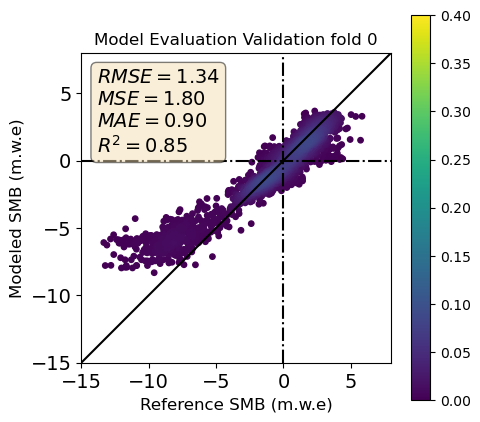

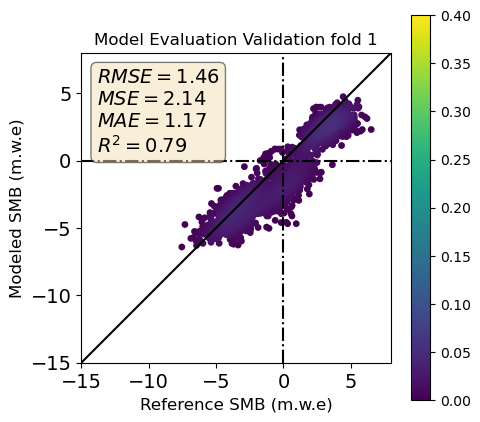

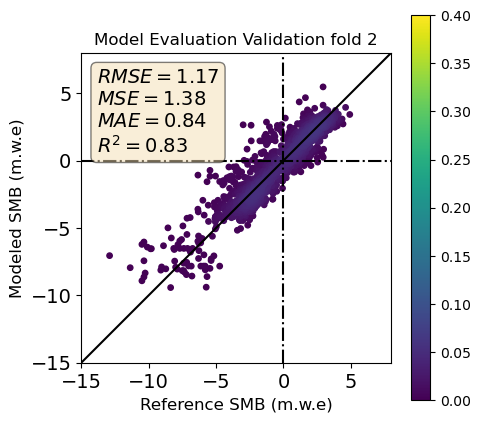

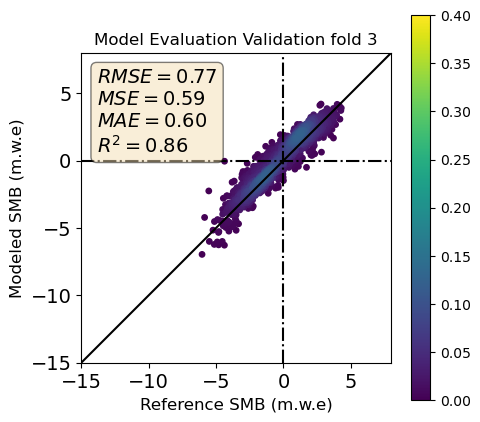

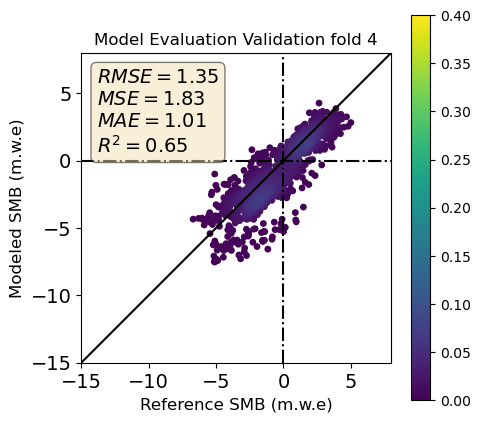

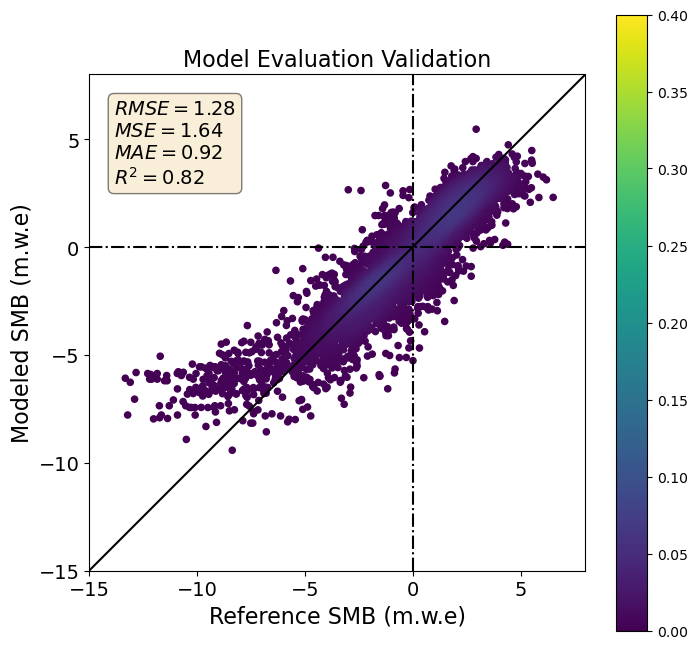

In [68]:
# Train model
# Set return_train to False to inhibit return training scores. Default is True.
cv_grid, best_model, cvl_scores = train_xgb_model(X_train_s, y_train_s, splits_s, param_ranges, 
                                                  scorer='neg_mean_squared_error', return_train=True)

In [69]:
joblib.dump(cv_grid, 'Models/Final_training/cv_block_glacier_5fold_minimal_climate_ann_seas.pkl')


['Models/Final_training/cv_block_glacier_5fold_minimal_climate_ann_seas.pkl']